In [1]:
%env CUDA_VISIBLE_DEVICES=GPU-789a4674-4ff1-2bbc-4f59-c4540006f305

env: CUDA_VISIBLE_DEVICES=GPU-789a4674-4ff1-2bbc-4f59-c4540006f305


In [2]:
#load libraries
import pandas as pd
import os
import numpy as np
from datetime import datetime
from ultralytics import YOLO
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [3]:
#import images and models
file_path = '/home/lero/idrive/cmac/DDMAP/Stability studies'

folders = ['Image_analysis_test']
# folders = ['40_C_75_RH',
#            '40_C_75_RH',
#            '30_C_30_RH'
#           ]

wells_detection_model_path= '/home/lero/idrive/cmac/DDMAP/Image_analysis/Code/wells_model/Results/fold_3/weights/best.pt'
crystal_detection_model_path = '/home/lero/idrive/cmac/DDMAP/Image_analysis/Code/cryst_amorphous_model/Results/fold_1/weights/best.pt'

wells_detection_model = YOLO(wells_detection_model_path)
crystal_detection_model = YOLO(crystal_detection_model_path)

ignored_classes = {'Label'}

In [4]:
#create functions

# Function to convert filename timestamp to datetime object
def convert_timestamp(filename):
    # ignore extension (last 4 chars)
    return datetime.strptime(filename[:-4], "%Y%m%d_%H%M%S")

def calculate_crystal_pixels(image):
    """
    Calculate mean pixel intensity from circular well region using Hough Circle Transform.
    This version uses Gaussian filter and Otsu's thresholding, enforced to be >= 70.
    """
    if image is None or image.size == 0:
        return 0.0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- Prepare save folders ---
    roi_folder = os.path.join(output_folder, "roi")
    post_folder = os.path.join(output_folder, "post_threshold")
    hist_folder = os.path.join(output_folder, "histograms") 
    os.makedirs(post_folder, exist_ok=True)
    os.makedirs(roi_folder, exist_ok=True)
    os.makedirs(hist_folder, exist_ok=True)
    
    # Detect circles on the raw grayscale image
    circles = cv2.HoughCircles(
        gray, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2,       # inverse ratio of accumulator resolution
        minDist=80,     # min dist between circle centers
        param1=100,     # higher threshold for Canny edge detector
        param2=20,      # accumulator threshold (lower → more circles)
        minRadius=50, 
        maxRadius=128
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0][0]

        r = max(0, r - 40) #----- to remove well exterior

        mask = np.zeros_like(gray, dtype=np.uint8)
        cv2.circle(mask, (x, y), r, 255, -1)

        roi = cv2.bitwise_and(gray, gray, mask=mask)
        # roi_filename = f"roi_{image_name}"
        # cv2.imwrite(os.path.join(roi_folder, roi_filename), roi)

        # --- Gaussian Filter ---
        roi_blurred = cv2.GaussianBlur(roi, ksize=(21, 21), sigmaX=0)
        
        # --- Otsu's Thresholding ---
        roi_for_otsu = roi_blurred.copy()
        temp_otsu_threshold, _ = cv2.threshold(
            roi_for_otsu, 
            0, 
            255, 
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        
        # Minimum Threshold ---
        MIN_THRESHOLD = 70
        
        if temp_otsu_threshold < MIN_THRESHOLD:
            # If Otsu's is too low, use the minimum required value
            final_threshold = MIN_THRESHOLD
            threshold_source = "Forced (Min 70)"
        else:
            # Otherwise, use the calculated Otsu's value
            final_threshold = temp_otsu_threshold
            threshold_source = "Otsu's"

        # Apply the final determined threshold (Inverse Binary: white crystals on dark background)
        _, binary = cv2.threshold(
            roi_for_otsu, 
            final_threshold, 
            255, 
            cv2.THRESH_BINARY_INV
        )

        # --- hist ---
        well_pixels = roi_blurred[roi_blurred > 0]
        if well_pixels.size > 0:
            hist, bins = np.histogram(well_pixels, bins=256, range=[1,255])
            
            # plt.figure(figsize=(6, 4))
            # plt.plot(bins[:-1], hist, color='gray', label='Blurred ROI Histogram', alpha=0.5) 
            
            # # Plot the final applied threshold
            # plt.axvline(final_threshold, color='red', linestyle='--', linewidth=2, label=f"Applied Threshold ({final_threshold:.2f}, {threshold_source})")
            
            # # Optionally plot the original Otsu's value for comparison
            # if final_threshold != temp_otsu_threshold:
            #      plt.axvline(temp_otsu_threshold, color='blue', linestyle=':', linewidth=1, label=f"Otsu's Only ({temp_otsu_threshold:.2f})")
            
            # plt.title(f'Histogram with Enforced Threshold (>= {MIN_THRESHOLD})')
            # plt.xlabel('Pixel Intensity')
            # plt.ylabel('Pixel Count')
            # plt.legend()
            # plt.grid(True, linestyle=':', alpha=0.6)
            # plt.tight_layout()
            # plt.yscale("log")
            
            # hist_filename = f"hist_{image_name.replace('.png', '.jpg').replace('.jpeg', '.jpg')}" 
            # plt.savefig(os.path.join(hist_folder, hist_filename), dpi=200)
            # plt.close() 

        # --- Save post-threshold image ---
        # binary_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        # cv2.imwrite(os.path.join(post_folder, image_name), binary_color)

        # -Count white (crystal) pixels within mask ---
        crystal_pixels = cv2.countNonZero(binary)

        return crystal_pixels

    else:
        # fallback if no circle is detected
        return 0

# Color coding for object classes
class_colors = {
    "Dust": (255, 0, 0),  # Red
    "Amorphous": (0, 255, 0),  # Green
    "Crystal": (255, 255, 0)  # Cyan
}

processing Naproxen in folder Image_analysis_test


  7%|█████▊                                                                          | 8/109 [03:41<46:33, 27.66s/images]


KeyboardInterrupt: 

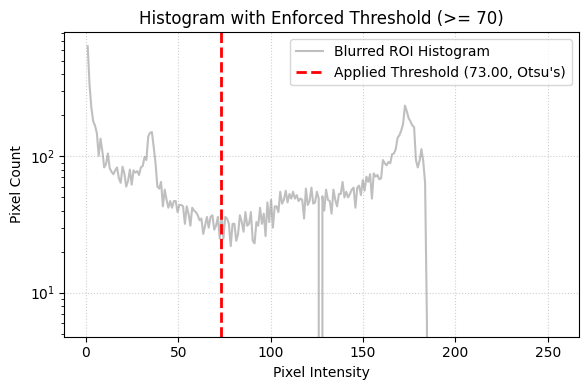

In [5]:
#-------run detection model--------#

for folder in folders:
    folder_path = os.path.join(file_path, folder)
    #Image pathway
    for api in os.listdir(folder_path):
        image_folder = os.path.join(folder_path, api)
        if not os.path.isdir(image_folder):
            continue
        print(f'processing {api} in folder {folder}')
        #output folder
        output_folder = os.path.join(image_folder, 'new_results')
        os.makedirs(output_folder, exist_ok=True)

        #get sorted images
        images = sorted(img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg')))
        if not images:
            print(f'no images found in {image_folder}, skipping')
            continue

        #get the first image timestamp
        assert len(images)
        first_image_timestamp = convert_timestamp(images[0])
        first_image_timestamp_str = first_image_timestamp.strftime("%d-%m-%Y %H:%M")

        # Dictionary to track object states
        object_last_state = {}
        object_detections = {}
        object_positions = []

        wells = list(range(96))
        well_data = {wi: [] for wi in wells}
        stability_results = {wi:{'Timestamp':None, 'Class': None} for wi in wells}
        WINDOW = 80

        #read and process images
        for idx, image_name in enumerate(tqdm(images, unit='images')):
            image_path = os.path.join(image_folder, image_name)
            img = cv2.imread(image_path) #image of well plate

            results = wells_detection_model(img, verbose=False)
            located_wells = []

            for result in results:
                for box in result.boxes:
                    cls_id = int(box.cls)
                    cls_name = result.names[cls_id]
                    conf = round(float(box.conf), 2)

                    if cls_name in ignored_classes:
                        continue

                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                    located_wells.append((x1, y1, x2, y2, center_x, center_y, cls_name, conf)) 
            # --- CHECK-----
            #print(f"Image {image_name}: Found {len(located_wells)} wells")
            
            normalised_wells = []
            #normalise grid based on well [0] and map all wells into grid positions
            if located_wells:
                all_confs = sorted([o[-1] for o in located_wells], reverse=True)

                x = [o[4] for o in located_wells if o[-1] > 0.75]
                y = [o[5] for o in located_wells if o[-1] > 0.75]
                left = min(x)
                right = max(x)
                top = min(y)
                bottom = max(y)
                width = right - left
                height = bottom - top
                reference_well = min(located_wells, key=lambda o: (o[5], o[4])) #since origin of image is (0,0)
                ref_x, ref_y = reference_well[4], reference_well[5]

                for obj in located_wells:
                    x1, y1, x2, y2, center_x, center_y, cls_name, conf = obj
                    midp_x = (x1+x2)/2
                    midp_y = (y1+y2)/2
                    x_coord = int((midp_x - left)*12/width/1.03)
                    y_coord = int((midp_y - top)*8/height)
                    x_coord = min(11, max(0, x_coord)) #set min and max rows from 0,11
                    y_coord = min(7, max(0, y_coord)) #set min and max columns from 0,7
                    normalised_wells.append((x1, y1, x2, y2, center_x, center_y, cls_name, conf, x_coord, y_coord))
                
                #keep only the best detections per grid 
                best_detections = {}
                for obj in normalised_wells:
                    x1, y1, x2, y2, center_x, center_y, cls_name, conf, x_coord, y_coord = obj
                    well_key = (x_coord, y_coord)
                    if well_key not in best_detections or conf > best_detections[well_key][7]:
                        best_detections[well_key] = obj
                normalised_wells = list(best_detections.values())


            #-----take patches------#
            for patch in normalised_wells:
                x1, y1, x2, y2, center_x, center_y, cls_name, conf, x_coord, y_coord = patch
                well_key = y_coord*12+x_coord #0-95 indexing
                #crop the patch using the coordinates from grid position
                well_crop = img[y1:y2, x1:x2]
                ##--possible to save well image here--##

                crystal_results = crystal_detection_model(well_crop, verbose=False)
                
                #extract top classification prediction
                top_cls_name=None
                top_conf= 0
                for res in crystal_results:
                    for crop in res.boxes:
                        patch_cls_id = int(crop.cls)
                        patch_conf = float(crop.conf)
                        if patch_conf > top_conf:
                            top_conf = patch_conf
                            top_cls_name = res.names[patch_cls_id]


                #calculate mean pixel intensity
                if top_cls_name in ['Dust','Amorphous']:
                    if well_data[well_key]:
                        crystal_number_pixels = well_data[well_key][-1]['crystal_number_pixels']
                    else:
                        crystal_number_pixels = 0
                else:
                    crystal_number_pixels = calculate_crystal_pixels(well_crop)
                            
                #store result
                well_data[well_key].append({
                    "image": image_name,
                    "crop_coords": (x1, y1, x2, y2),
                    "class": top_cls_name,
                    "conf": top_conf,
                    "crystal_number_pixels": crystal_number_pixels
                })   

            #----annotate every 50th image for a visual check----#
            if idx % 50 == 0 and normalised_wells:
                annotated_img = img.copy()
                for patch_info in normalised_wells:
                    x1, y1, x2, y2, center_x, center_y, cls_name, conf, x_coord, y_coord = patch_info
                    well_key = y_coord * 12 + x_coord  # 0-95 index
            
                    if well_data.get(well_key):
                        top_result = well_data[well_key][-1]  # last classification for this image
                        label = f"Well {well_key}: {top_result['class']}, ({top_result['conf']:.2f})"
            
                        # Draw rectangle and label
                        color = class_colors.get(top_result['class'], (255, 255, 255))  # default white
                        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(annotated_img, label, (x1, y1 - 5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            
                annotated_path = os.path.join(output_folder, f"annotated_{idx:04d}_{image_name}")
                cv2.imwrite(annotated_path, annotated_img)
                #print(f"✅ Saved annotated frame #{idx}: {annotated_path}")


            #----------- calculate well stability over time ----------#
            for well_key in wells:
                entries = well_data[well_key]
                if stability_results[well_key]['Class'] is None and len(entries) >= WINDOW:
                    for i in range(len(entries) - WINDOW + 1):
                        current_class = entries[i]["class"]
                        if current_class == 'Crystal':
                            next_classes = [e['class'] for e in entries[i:i+WINDOW]]
    
                            if all(c=='Crystal' for c in next_classes):
                                stability_results[well_key]["Timestamp"] = entries[i]['image']
                                stability_results[well_key]['Class'] = 'Unstable'
                                break

        
        for well_key, entries in well_data.items():
            rows = []
            for entry in entries:
                rows.append({
                    "well": well_key,
                    "timestamp": entry["image"],
                    "class": entry["class"],
                    "crystal_number_pixels": entry["crystal_number_pixels"]
                })
            #if a well is not detected
            if not rows:
                continue #skip to next well key
        
            well_df = pd.DataFrame(rows)
            well_df_path = os.path.join(output_folder, f"well_{well_key}_data.csv")
            well_df.to_csv(well_df_path, index=False)
            #print("well data saves as csv")
            
            #-----plot well stability and mean pixel intensity -------#
            plt.figure(figsize=(4,3), dpi=500)
            #prep
            well_df["Timestamp_dt"] = well_df["timestamp"].apply(lambda fn: convert_timestamp(fn))
            rel_time = well_df["Timestamp_dt"].astype('int64') / (10**9) / 3600
            cryst_or_no = well_df['class'].map(lambda c: 1 if c == "Crystal" else 0)
            if not len(rel_time):
                continue
            rel_time -= rel_time[0]

            #plot cryst vs time
            plt.plot(rel_time, cryst_or_no, 'C0')
            plt.xlabel('Time (hrs)')
            plt.yticks([0,1], ['No', 'Yes'], color='C0')
            plt.ylabel('crystallised?', color='C0')
            plt.twinx()

            #plot mean intensity vs time
            plt.plot(rel_time, well_df["crystal_number_pixels"], 'C1')
            plt.ylabel('Normalised mean pixel intensity', color = 'C1')
            #plt.ylim(bottom = 0, top = 1)

            #draw cryst marker if exists
            unstable_image = stability_results[well_key]["Timestamp"]
            if unstable_image is not None:
                unstable_time = convert_timestamp(unstable_image)
                unstable_hours = (unstable_time - well_df["Timestamp_dt"].iloc[0]).total_seconds() / 3600
                plt.title(f'Crystallises after {unstable_hours:.2f} hours')
                plt.axvline(unstable_hours, color='k', linestyle='--', lw=2)
            else:
                plt.title('Infinitely stable')

            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'well_{well_key}_stability_figure.png'))
            plt.close()
            

        stability_rows = []
        for well_key, info in stability_results.items():
            stability_rows.append({
                "well": well_key,
                "unstable_timestamp": info["Timestamp"],
                "status": info["Class"] if info["Class"] else "Stable"
            })
        
        stability_df = pd.DataFrame(stability_rows)
        
        stability_df_path = os.path.join(output_folder, "stability_results.csv")
        stability_df.to_csv(stability_df_path, index=False)
        print("✅ stability_results saved as CSV")

print('hopefully done')                                 